In [111]:
import given

import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from matplotlib.patches import Polygon

In [112]:
with open('output.txt', 'r') as file:
    line = file.readline()
    R_star = int(line)

In [113]:
def manhattan_distance(x, y):
    return abs(x[0]-y[0]) + abs(x[1]-y[1])

## Create a Flow Network

In [114]:
def form_clusters(t):
    clients = given.clients1 if t == 0 else given.clients2

    uncovered = set(range(len(clients)))
    clusters = []
    cluster_centers = []

    while uncovered:
        # Pick a random uncovered client as cluster center
        center_idx = random.choice(list(uncovered))
        center = clients[center_idx]

        # Form a cluster with all clients within 2R
        cluster = {i for i in uncovered if manhattan_distance(clients[i], center) <= 2 * R_star}
        clusters.append(cluster)
        cluster_centers.append(center)
        uncovered -= cluster
    
    # Add dummy clusters if needed
    if len(cluster_centers) < given.k:
        extra = given.k - len(cluster_centers)
        dummy_centers = [-1 for _ in range(extra)]
        dummy_clusters = [[-1] for _ in range(extra)]
        cluster_centers.extend(dummy_centers)
        clusters.extend(dummy_clusters)

    return cluster_centers, clusters

In [115]:
# Define number of layers and nodes per layer
num_layers = 4
nodes_per_layer = [given.k, len(given.facilities1), len(given.facilities2), given.k]  # example: L0 has 2 nodes, L1 has 3, etc.

# Create a directed graph
G = nx.DiGraph()

In [116]:
G.add_nodes_from(["s","t"])

# Add layers one by one
layers = [[] for _ in range(4)]
clusters = [[],[]]
layers[0], clusters[0] = form_clusters(0)
layers[1] = given.facilities1
layers[2] = given.facilities2
layers[3], clusters[1] = form_clusters(1)

node_counter = 0
for i, size in enumerate(nodes_per_layer):
    layer_nodes = [f"L{i}_N{j}" for j in range(size)]
    G.add_nodes_from(layer_nodes)

#add edges in between layers

#layer0 and layer1 ---> facility should be located within R_star distance
for i,cluster_center in enumerate(layers[0]):
    G.add_edge("s",f"L0_N{i}",capacity=1)
    for j,facility in enumerate(layers[1]):
        if cluster_center==-1:
            G.add_edge(f"L0_N{i}", f"L1_N{j}", capacity=1)
            continue
        dist = manhattan_distance(facility, cluster_center)
        if dist <= R_star:
            # L0_N{i} to L1_N{j}
            G.add_edge(f"L0_N{i}", f"L1_N{j}", capacity=1)

#layer1 and layer2 ---> facility movement should be max B
for i,facility1 in enumerate(layers[1]):
    for j,facility2 in enumerate(layers[2]):
        dist = manhattan_distance(facility1, facility2)
        if dist <= given.B:
            # L0_N{i} to L1_N{j}
            G.add_edge(f"L1_N{i}", f"L2_N{j}", capacity=1e9)


#layer2 and layer3 ---> facility should be located within R_star distance
for i,facility in enumerate(layers[2]):
    for j,cluster_center in enumerate(layers[3]):
        if cluster_center==-1:
            G.add_edge(f"L2_N{i}", f"L3_N{j}", capacity=1)
            continue
        dist = manhattan_distance(facility, cluster_center)
        if dist <= R_star:
            # L0_N{i} to L1_N{j}
            G.add_edge(f"L2_N{i}", f"L3_N{j}", capacity=1)

#layer3 and sink
for j,cluster_center in enumerate(layers[3]):
    G.add_edge(f"L3_N{j}", "t", capacity=1)



## Visualize network

/var/folders/y6/5sz264vj40jcwv97yh_28c7r0000gn/T/ipykernel_99735/1229873159.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


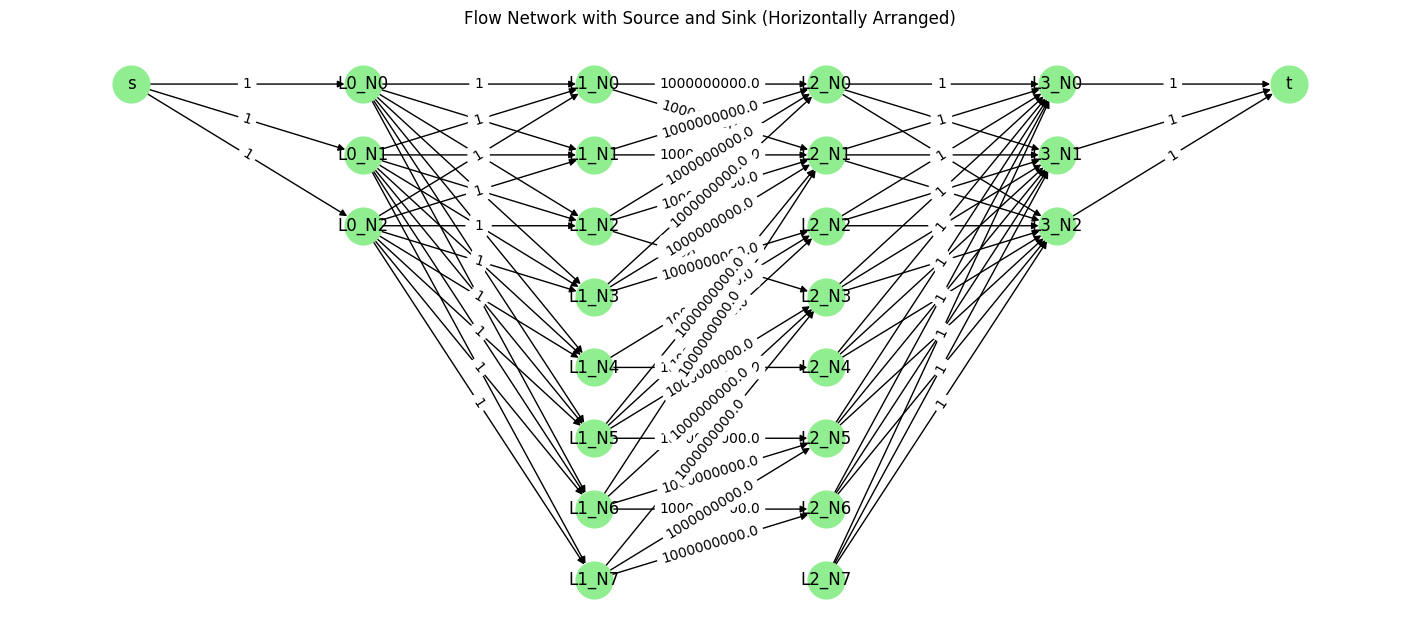

In [117]:
def get_layer_index(node):
    """Extract the layer index from node name like 'L0_N3'."""
    if node == 's':
        return -1  # Before first layer
    elif node == 't':
        return 4   # After last layer
    return int(node[1])  # e.g., 'L0_N3' -> 0


def generate_layered_pos_horizontal(G, layer_gap=4, node_gap=1):
    """
    Generate a layout where layers are arranged horizontally,
    and nodes within each layer are stacked vertically.
    Includes source 's' and sink 't' placed at both ends.
    """
    pos = {}
    max_layer = 4  # 0-3 + 't'
    layers = {i: [] for i in range(-1, max_layer + 1)}  # Include s (-1) and t (4)

    # Group nodes by their layer
    for node in G.nodes:
        layer = get_layer_index(node)
        layers[layer].append(node)

    # Assign positions for each layer
    for layer_idx, nodes in layers.items():
        for j, node in enumerate(sorted(nodes)):
            pos[node] = (layer_idx * layer_gap, -j * node_gap)

    return pos


# Create layout
pos = generate_layered_pos_horizontal(G)

# Draw the graph
plt.figure(figsize=(14, 6))
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=700, arrows=True)

# Optional: draw edge labels (e.g., capacities)
edge_labels = nx.get_edge_attributes(G, 'capacity')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Flow Network with Source and Sink (Horizontally Arranged)")
plt.axis('off')
plt.tight_layout()
plt.show()


## Find Solution

In [118]:
flow_value, flow_dict = nx.maximum_flow(G, "s", "t")
print("Max Flow:", flow_value)
print("Flow Details:")
for u in flow_dict:
    for v in flow_dict[u]:
        print(f"{u} -> {v} : {flow_dict[u][v]}")

Max Flow: 3
Flow Details:
s -> L0_N0 : 1
s -> L0_N1 : 1
s -> L0_N2 : 1
L0_N0 -> L1_N0 : 1
L0_N0 -> L1_N1 : 0
L0_N0 -> L1_N2 : 0
L0_N0 -> L1_N3 : 0
L0_N0 -> L1_N4 : 0
L0_N0 -> L1_N5 : 0
L0_N0 -> L1_N6 : 0
L0_N1 -> L1_N0 : 1
L0_N1 -> L1_N1 : 0
L0_N1 -> L1_N2 : 0
L0_N1 -> L1_N3 : 0
L0_N1 -> L1_N4 : 0
L0_N1 -> L1_N5 : 0
L0_N1 -> L1_N6 : 0
L0_N1 -> L1_N7 : 0
L0_N2 -> L1_N0 : 1
L0_N2 -> L1_N1 : 0
L0_N2 -> L1_N2 : 0
L0_N2 -> L1_N3 : 0
L0_N2 -> L1_N4 : 0
L0_N2 -> L1_N5 : 0
L0_N2 -> L1_N6 : 0
L0_N2 -> L1_N7 : 0
L1_N0 -> L2_N0 : 3
L1_N0 -> L2_N1 : 0
L1_N1 -> L2_N0 : 0
L1_N1 -> L2_N1 : 0
L1_N2 -> L2_N0 : 0
L1_N2 -> L2_N1 : 0
L1_N2 -> L2_N3 : 0
L1_N3 -> L2_N0 : 0
L1_N3 -> L2_N1 : 0
L1_N3 -> L2_N2 : 0
L1_N4 -> L2_N2 : 0
L1_N4 -> L2_N4 : 0
L1_N5 -> L2_N1 : 0
L1_N5 -> L2_N2 : 0
L1_N5 -> L2_N3 : 0
L1_N5 -> L2_N5 : 0
L1_N6 -> L2_N1 : 0
L1_N6 -> L2_N3 : 0
L1_N6 -> L2_N5 : 0
L1_N6 -> L2_N6 : 0
L1_N7 -> L2_N3 : 0
L1_N7 -> L2_N5 : 0
L1_N7 -> L2_N6 : 0
L2_N0 -> L3_N0 : 1
L2_N0 -> L3_N1 : 1
L2_N0 -> L3_N2 : 

## Visualize Solution in form of clusters and facility placements

In [119]:
facility_movements = defaultdict(list)

for i, facility in enumerate(layers[1]):
    for moved_to, fv in flow_dict[f"L1_N{i}"].items():
        if fv != 0:
            facility_movements[tuple(facility)].append(layers[2][int(moved_to[4])])

print(facility_movements)

defaultdict(<class 'list'>, {(0, 1): [[1, 2]]})


In [134]:
def visualize_clusters_and_facilities(clients1, clients2, facility_movements, R_star, layers):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    axs = axs.flatten()

    def draw_state(client, ax, time_label, cluster_layer_idx, color):
        ax.set_title(f"Time = {time_label}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.grid(True)

        # Plot clients
        x_vals, y_vals = zip(*client)
        ax.scatter(x_vals, y_vals, c='black', label='Clients', marker='x')

        # Plot cluster centers (skip dummy clusters)
        for i, idx in enumerate(layers[cluster_layer_idx]):
            if idx == -1:
                continue  # Skip dummy clusters
            cx, cy = idx

            # Draw Manhattan "circle" (diamond) of radius 2 * R_star
            diamond = Polygon([
                (cx, cy + 2 * R_star),
                (cx + 2 * R_star, cy),
                (cx, cy - 2 * R_star),
                (cx - 2 * R_star, cy)
            ], closed=True, edgecolor='gray', linestyle='--', facecolor='none')
            ax.add_patch(diamond)
            ax.scatter(cx, cy, c='orange', marker='o', label='Cluster Center' if i == 0 else "")

        # Plot facilities
        if time_label == '0':
            facilities = []
            for loc, dests in facility_movements.items():
                facilities.extend([loc] * len(dests))
        else:
            facilities = []
            for dests in facility_movements.values():
                facilities.extend(dests)

        for i, f in enumerate(facilities):
            ax.scatter(f[0], f[1], c=color, s=80, label='Facility' if i == 0 else "")

        ax.legend()

    draw_state(clients1, axs[0], time_label='0', cluster_layer_idx=0, color='red')
    draw_state(clients2, axs[1], time_label='1', cluster_layer_idx=3, color='blue')

    # Add arrows to show movement from t=0 to t=1
    for origin, destinations in facility_movements.items():
        for dest in destinations:
            axs[1].arrow(origin[0], origin[1], dest[0] - origin[0], dest[1] - origin[1],
                         head_width=0.3, head_length=0.3, fc='green', ec='green', alpha=0.7, linestyle='-')


    plt.tight_layout()
    plt.show()

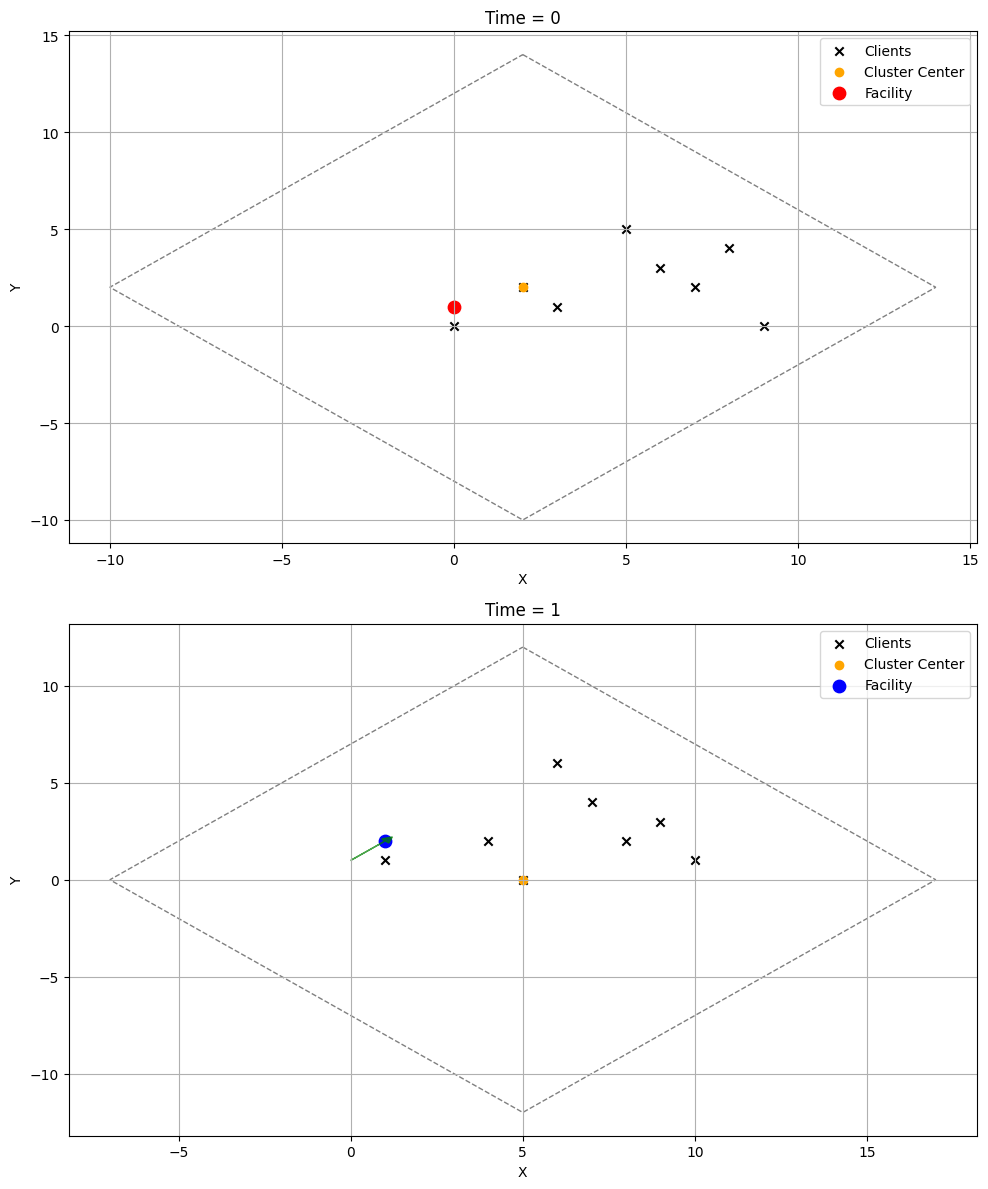

In [135]:
visualize_clusters_and_facilities(given.clients1, given.clients2, facility_movements, R_star, layers)